In [1]:
from os import path
import pickle

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use('apw-notebook')
%matplotlib inline
import sqlutil
from scipy.stats import binned_statistic_dd
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
import astropy.units as units

In [2]:
def queryDatabase(query, columns, post_query, cache_file='db.pickle'):

    #cache_file = "reducedPM2.pickle"

    if not path.exists(cache_file):
        res = sqlutil.get(query.format(','.join(columns), post_query),
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)

        with open(cache_file, "wb") as f:
            pickle.dump(res, f)
        
    else:
        with open(cache_file, "rb") as f:
            res = pickle.load(f)
    return res

In [3]:
def dust(l, b):
    c = SkyCoord(l, b, frame='galactic')
    sfd = SFDQuery()
    dust = sfd(c)
    return dust

In [4]:
def reducedPM(pmra, pmdec, mag):
    pm = np.sqrt(pmra**2. + pmdec**2.)
    return mag + 5.*np.log10(pm) + 5.

In [5]:
dustCoeff = {'B': 3.626,
                   'V': 2.742,
                   'g': 3.303,
                   'r': 2.285,
                   'i': 1.698,
                   'J': 0.709,
                   'H': 0.449,
                   'K': 0.302,
                   'G': 2.55}
dustCoeffZeros = {'B': 0.0,
                  'V': 0.0,
                  'g': 0.0,
                  'r': 0.0,
                  'i': 0.0,
                  'J': 0.0,
                  'H': 0.0,
                  'K': 0.0,
                  'G': 0.0}

In [6]:
columns = '*'
query = "Select {0} FROM gaia_dr1.gaia_source {1}"
cuts = 'LIMIT 10'
res = queryDatabase(query, columns, cuts, cache_file='gaiaListColumns')
tbl = Table(res)
tbl.keys()

['solution_id',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_good_obs_ac',
 'astrometric_n_bad_obs_al',
 'astrometric_n_bad_obs_ac',
 'astrometric_delta_q',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_primary_flag',
 'astrometric_relegation_factor',
 'astrometric_weight_al',
 'astrometric_weight_ac',
 'astrometric_priors_used',
 'matched_observations',
 'duplicated_source',
 'scan_direction_strength_k1',
 'scan_direction_strength_k2',
 'scan_direction_strength_k3',
 'scan_direction_strength_k4',
 'scan_direction_mean_k1',
 'scan_direction_mean_

In [7]:
columns = '*'
query = "Select {0} FROM gaia_dr1_aux.gaia_source_sdssdr9_xm_new {1}"
cuts = "LIMIT 10"
res = queryDatabase(query, columns, cuts, cache_file='sdssListColumns')
tbl = Table(res)
tbl.keys()

['solution_id',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_good_obs_ac',
 'astrometric_n_bad_obs_al',
 'astrometric_n_bad_obs_ac',
 'astrometric_delta_q',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_primary_flag',
 'astrometric_relegation_factor',
 'astrometric_weight_al',
 'astrometric_weight_ac',
 'astrometric_priors_used',
 'matched_observations',
 'duplicated_source',
 'scan_direction_strength_k1',
 'scan_direction_strength_k2',
 'scan_direction_strength_k3',
 'scan_direction_strength_k4',
 'scan_direction_mean_k1',
 'scan_direction_mean_

In [8]:
sdsscolumns = [
    'random_index', 'source_id', 'ra', 'dec', 'l', 'b', 
    'pmra_new', 'pmdec_new', 'gs_pmra', 'gs_pmdec', 'extinction_u', 
    'extinction_g', 'extinction_r', 'extinction_i', 'extinction_z',
    'psfmag_u', 'psfmag_g', 'psfmag_r', 'psfmag_i', 'psfmag_z', 'phot_g_mean_mag']
query = "Select {0} FROM gaia_dr1_aux.gaia_source_sdssdr9_xm_new {1}"
cuts = """WHERE MOD(random_index, 10) = 0 AND 
sqrt(power(2.5/log(10)*phot_g_mean_flux_error/phot_g_mean_flux,2)) <= 0.05
"""
res = queryDatabase(query, sdsscolumns, cuts, cache_file='gaiasdss.pkl')
sdsstbl = Table(res)

In [9]:
sdssdust = dust(sdsstbl['l']*units.deg, sdsstbl['b']*units.deg)
sdsstbl['reduced_pm'] = reducedPM(sdsstbl['pmra_new'], sdsstbl['pmdec_new'], sdsstbl['phot_g_mean_mag'] - sdssdust*dustCoeff['G'])
sdsscolor = sdsstbl['psfmag_g'] - sdssdust*dustCoeff['g'] - (sdsstbl['psfmag_i'] - sdssdust*dustCoeff['i'])
sdsstbl['reduced_pm_nodust'] = reducedPM(sdsstbl['pmra_new'], sdsstbl['pmdec_new'], sdsstbl['phot_g_mean_mag'])
sdsscolorNodust = sdsstbl['psfmag_g'] - sdsstbl['psfmag_i']

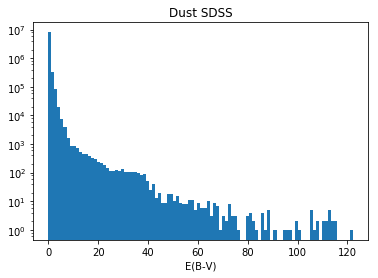

In [10]:
plt.hist(sdssdust, bins=100, log=True)
plt.xlabel('E(B-V)')
plt.title('Dust SDSS')

10693


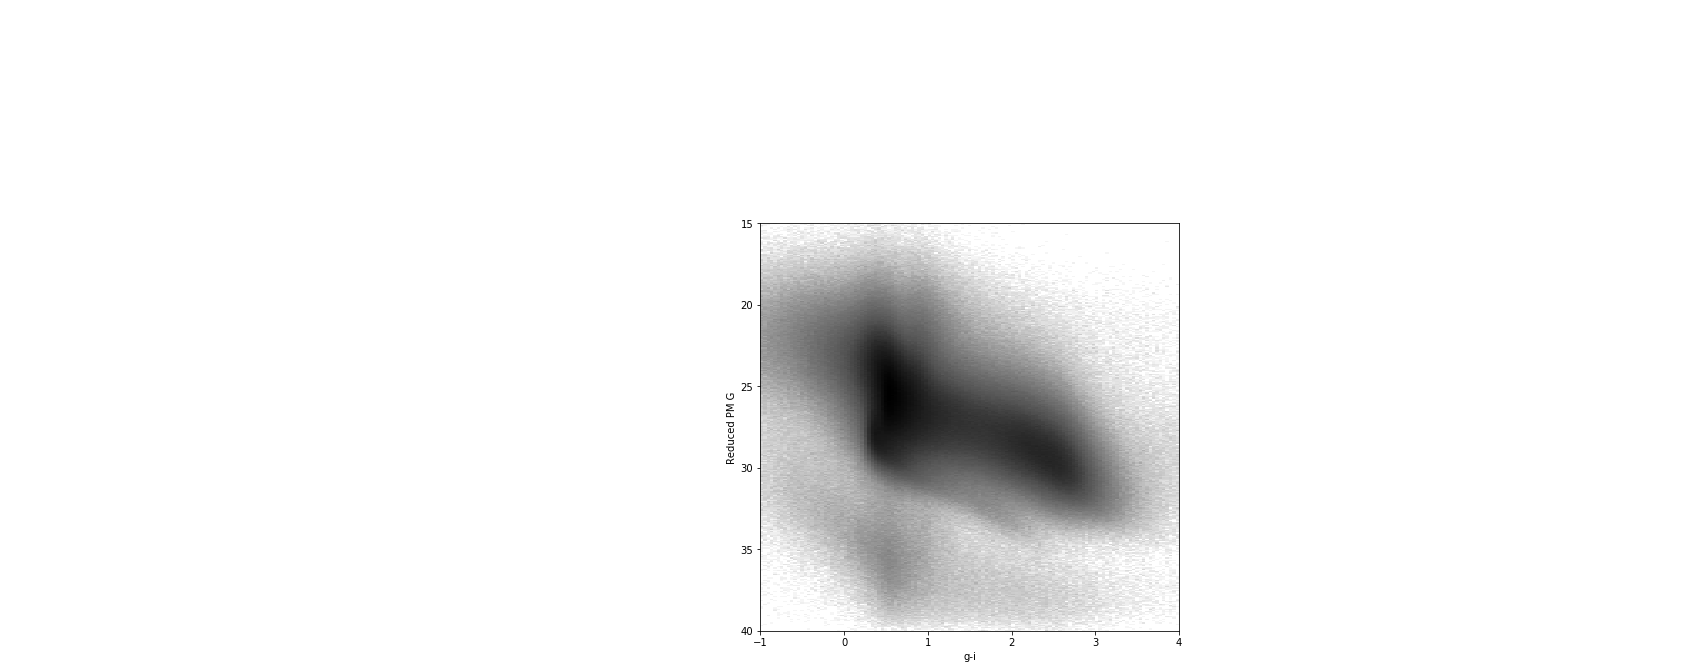

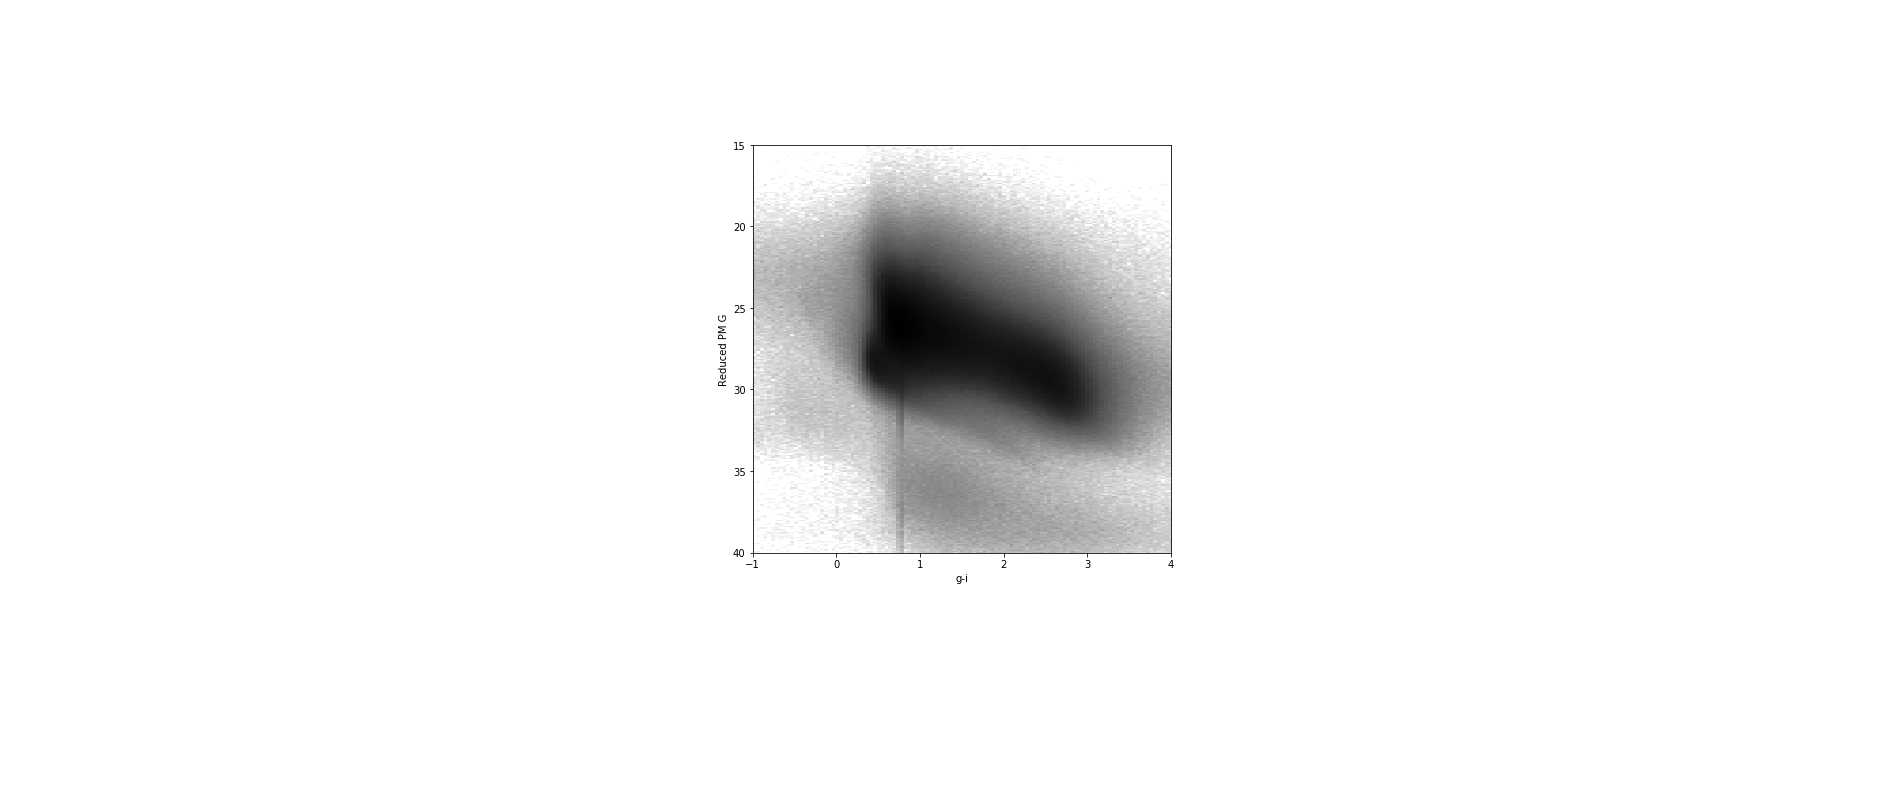

In [11]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
sdssgood = (np.abs(sdsscolor) < 10) & (sdsstbl['reduced_pm'] < 40) & (sdsstbl['reduced_pm'] > 0)
print np.sum(~sdssgood)
ax.hist2d(sdsscolor[sdssgood], sdsstbl['reduced_pm'][sdssgood], bins=500, cmap='Greys', norm=mpl.colors.LogNorm()) #, s=1, lw=0, alpha=0.5)
ax.set_ylim(40, 15)
ax.set_xlim(-1, 4)
ax.set_xlabel('g-i')
ax.set_ylabel('Reduced PM G')
#plt.colorbar(im)
plt.savefig('reducedPMSDSS.pdf')

fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.hist2d(sdsscolorNodust[sdssgood], sdsstbl['reduced_pm_nodust'][sdssgood], bins=500, cmap='Greys', norm=mpl.colors.LogNorm())
ax.set_ylim(40, 15)
ax.set_xlim(-1, 4)
ax.set_xlabel('g-i')
ax.set_ylabel('Reduced PM G')
#plt.colorbar(im)
plt.savefig('reducedPMSDSS_nodust.pdf')


In [12]:
sdsscolumns = [
    'random_index', 'source_id', 'ra', 'dec', 'l', 'b', 
    'pmra_new', 'pmdec_new', 'gs_pmra', 'gs_pmdec', 'extinction_u', 
    'extinction_g', 'extinction_r', 'extinction_i', 'extinction_z',
    'psfmag_u', 'psfmag_g', 'psfmag_r', 'psfmag_i', 'psfmag_z', 'phot_g_mean_mag']
query = "Select {0} FROM gaia_dr1_aux.gaia_source_sdssdr9_xm_new {1}"
cuts = """WHERE 
sqrt(power(2.5/log(10)*phot_g_mean_flux_error/phot_g_mean_flux,2)) <= 0.05 AND
abs(b) > 30
"""
res = queryDatabase(query, sdsscolumns, cuts, cache_file='gaiasdssHalo.pkl')
sdsstbl = Table(res)

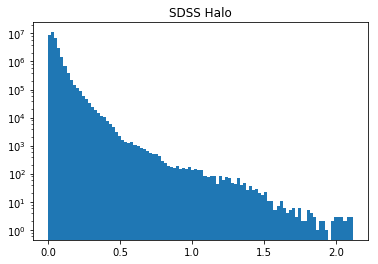

In [13]:
sdssdust = dust(sdsstbl['l']*units.deg, sdsstbl['b']*units.deg)
plt.hist(sdssdust, bins=100, log=True)
plt.title('SDSS Halo')

In [14]:
sdsstbl['reduced_pm'] = reducedPM(sdsstbl['pmra_new'], sdsstbl['pmdec_new'], sdsstbl['phot_g_mean_mag'] - sdssdust*dustCoeff['G'])
sdsstbl['reduced_pm_nodust'] = reducedPM(sdsstbl['pmra_new'], sdsstbl['pmdec_new'], sdsstbl['phot_g_mean_mag'])
sdsscolor = sdsstbl['psfmag_g'] - sdssdust*dustCoeff['g'] - (sdsstbl['psfmag_i'] - sdssdust*dustCoeff['i'])
sdsscolorNodust = sdsstbl['psfmag_g'] - sdsstbl['psfmag_i']

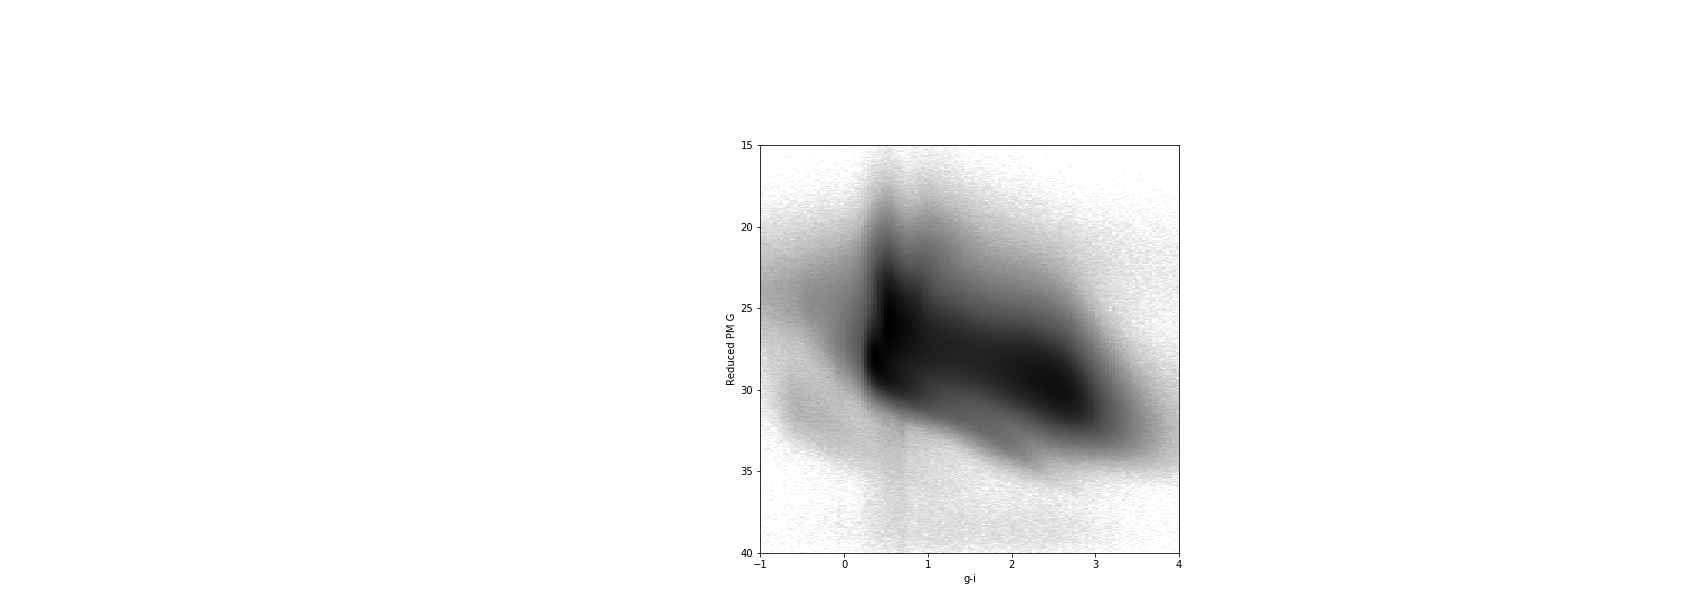

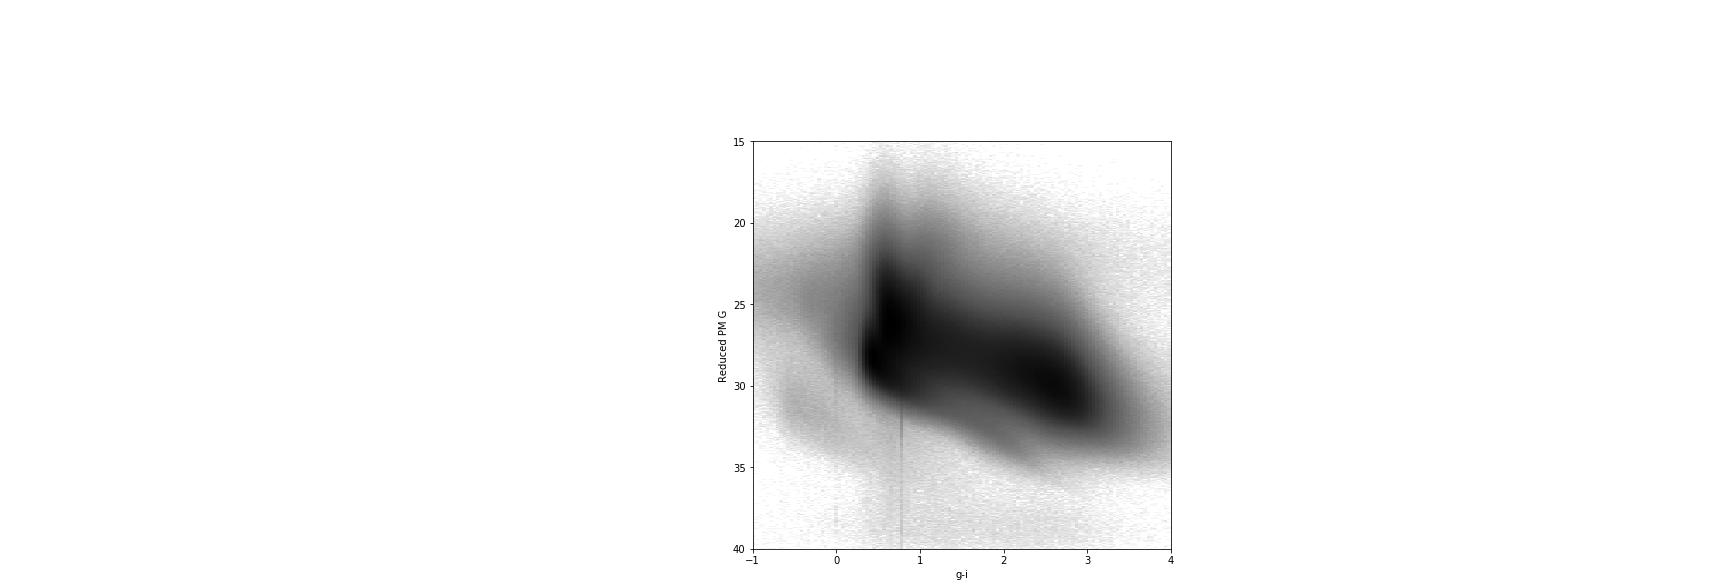

In [15]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
sdssgood = (np.abs(sdsscolor) < 10) & (sdsstbl['reduced_pm'] < 40) & (sdsstbl['reduced_pm'] > 0)
ax.hist2d(sdsscolor[sdssgood], sdsstbl['reduced_pm'][sdssgood], bins=500, cmap='Greys', norm=mpl.colors.LogNorm()) #, s=1, lw=0, alpha=0.5)
ax.set_ylim(40, 15)
ax.set_xlim(-1, 4)
ax.set_xlabel('g-i')
ax.set_ylabel('Reduced PM G')
#ax.colorbar()
plt.savefig('reducedPMHaloSDSS.pdf')

fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.hist2d(sdsscolorNodust[sdssgood], sdsstbl['reduced_pm_nodust'][sdssgood], bins=500, cmap='Greys', norm=mpl.colors.LogNorm())
ax.set_ylim(40, 15)
ax.set_xlim(-1, 4)
ax.set_xlabel('g-i')
ax.set_ylabel('Reduced PM G')
#plt.colorbar(im)
plt.savefig('reducedPMHaloSDSS_nodust.pdf')


In [16]:
from astropy.io import fits

In [17]:
file = '9.fits.gz'
unwise = Table.read(file, format='fits')

In [18]:
unwise.keys()

['ra',
 'dec',
 'pointsource',
 'w1_nanomaggies',
 'w1_nanomaggies_ivar',
 'w2_nanomaggies',
 'w2_nanomaggies_ivar',
 'w3_nanomaggies',
 'w3_nanomaggies_ivar',
 'w4_nanomaggies',
 'w4_nanomaggies_ivar',
 'sdss_flux',
 'sdss_flux_ivar']

In [21]:
from astropy.coordinates import ICRS
ra1 = sdsstbl['ra']*u.degree
dec1 = sdsstbl['dec']*u.degree
c = SkyCoord(ra1, dec1) #, unit=(u.degree, u.degree))
ra2 = unwise['ra']*u.degree
dec2 = unwise['dec']*u.degree
catalog = SkyCoord(ra2, dec2) #, unit=(u.degree, u.degree))


In [22]:
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

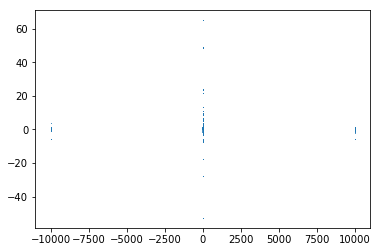

In [25]:
plt.scatter(sdsstbl['psfmag_g'] - sdsstbl['psfmag_i'], unwise['w1_nanomaggies'][idx]/unwise['w2_nanomaggies'][idx], s=1, lw=0)

In [26]:
np.save('unwise_index', idx)